# Création des quatres tables à partir des fichiers csv

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib
import pandas as pd
from IPython.display import display, HTML
import squarify

g_avail = pd.read_csv("~/public_health/csv/dispo_alimentaire.csv")
g_aid = pd.read_csv("~/public_health/csv/aide_alimentaire.csv")
g_demog = pd.read_csv("~/public_health/csv/population.csv")
g_undern = pd.read_csv("~/public_health/csv/sous_nutrition.csv")


# Création de variables qui seront utiles dans le calcul des résultats

In [2]:
#csv columns' names
img_path = 'plots/'
img_extension = '.png'
year = 'Année'
value = 'Valeur'
zone = 'Zone'
origin = 'Origine'
avail_kcal_p = 'Disponibilité alimentaire (Kcal/personne/jour)'
dom_avail = 'Disponibilité intérieure'
food = 'Nourriture'
animal_food = 'Aliments pour animaux'
loss = 'Pertes'
beneficiary_c = 'Pays bénéficiaire'
product = 'Produit'
export = 'Exportations - Quantité'
importation = 'Importations - Quantité'
production = 'Production'
treatement = 'Traitement'
seed = 'Semences'
other_use = 'Autres Utilisations'
#different variables used further
cereals = ['Blé','Céréales, Autres','Maïs','Millet','Orge','Riz (Eq Blanchi)','Avoine','Seigle','Sorgho']
stryear = ['2012-2014','2013-2015','2014-2016','2015-2017','2016-2018','2017-2019']
start_year = 2013

# Nettoyage des données

In [3]:

g_undern.loc[(g_undern[value] == '<0.1'),value]= 0

for i in range(len(stryear)):
    g_undern.loc[(g_undern[year] == stryear[i]),year]= start_year
    start_year = start_year + 1

g_undern[value]=pd.to_numeric(g_undern[value])

g_undern[value] = round(g_undern[value]*pow(10,6),0)
g_demog[value] = round(g_demog[value]*1000,0)

# Création de fonctions de calcul, format et visualisation de données

In [4]:
# Percentage ratio function

def ratio_f(value1,value2):
    result = round((value1/value2)*100,2)
    return result

# Font dictionnary function define font type, size,color ...
def title_font():
    titlefont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
            }
    return titlefont

# Bar chart function particularity color are define on value's weight
def bar_color(param1,param2,title,y_label,color_label,color):
    img_path = 'plots/'
    img_extension = '.png'
    data_color_normalized = [(x-min(param2)) / (max(param2)-min(param2)) for x in param2]
    fig, ax = plt.subplots(figsize=(30, 8.5))

    my_cmap = plt.cm.get_cmap(color)
    colors = my_cmap(data_color_normalized)

    rects = ax.bar(param1, param2, color=colors)
    sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(min(param2),max(param2)))

    sm.set_array([])

    cbar = plt.colorbar(sm)
    cbar.set_label(color_label, rotation=270,labelpad=25)


    
    plt.xticks(param1) 
    plt.xticks(rotation = 90)  
    plt.ylabel(y_label)

    plt.title(title,fontdict=title_font())
    plt.savefig(img_path+title+img_extension,dpi=300, bbox_inches='tight')
    plt.show()
# function that defines plot size 
def plot_size():
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(30, 7.5)

# function that formats values from table, format the value x of a cell with a certain string type
def format_datas(table,column,type):
    table[column] = table[column].apply(lambda x : type.format(x))

# Quelle est l'évolution du nombre de personne en sous-nutrition dans le monde depuis 2013 ?

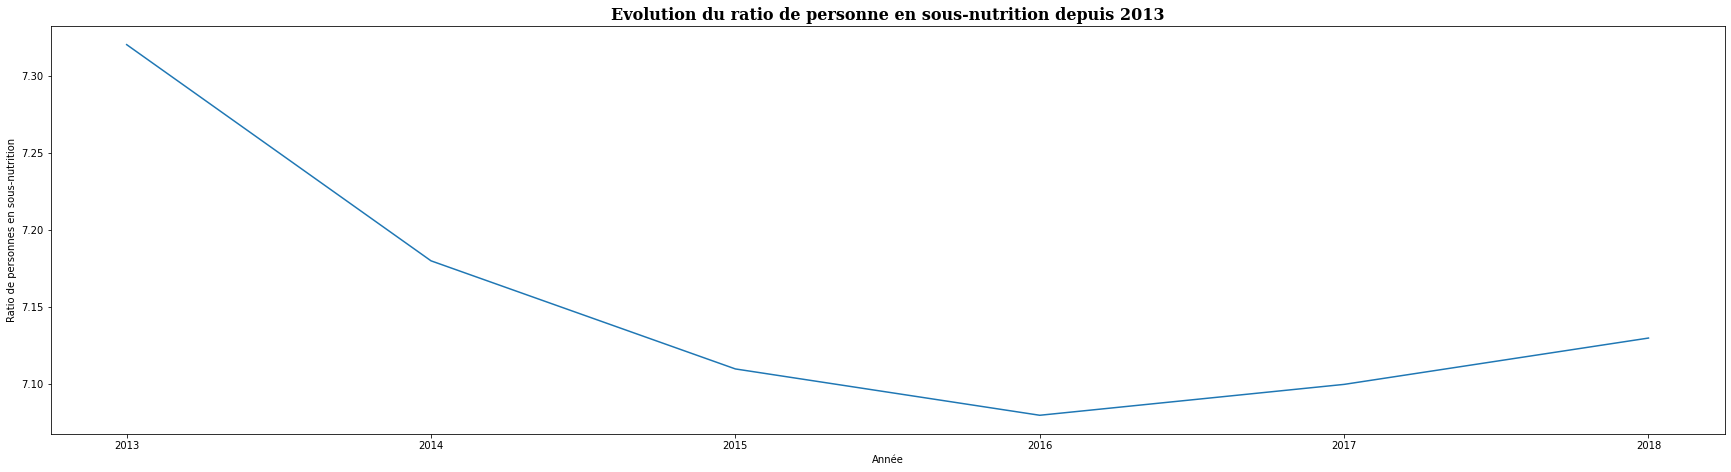

Année,Population totale,Population totale en sous-nutrition,Ratio de personnes en sous-nutrition
2013,"7,210,845,848.0","528,100,000.0",7.32%
2014,"7,295,557,771.0","523,500,000.0",7.18%
2015,"7,380,067,075.0","524,700,000.0",7.11%
2016,"7,464,294,742.0","528,600,000.0",7.08%
2017,"7,548,134,111.0","535,700,000.0",7.10%
2018,"7,631,368,523.0","544,200,000.0",7.13%


In [5]:
col_index1 = 'Population totale'
col_index2 = 'Population totale en sous-nutrition'
col_index3 = 'Ratio de personnes en sous-nutrition'


# Create worlwide population table and undernourished table and pop2017 variable might be usefull next

pop_per_year = g_demog.groupby(year)[value].sum().reset_index(name = col_index1)
POP_2017 = pop_per_year[col_index1][4]
undern_pop_per_year = g_undern.groupby(year)[value].sum().reset_index(name=col_index2)

#Result 1

#Merge worlwide population per year table and worldwide undernourished population
w_undern_pop_r = pd.merge(pop_per_year,undern_pop_per_year,how='inner',on=year)

#add a ratio column
w_undern_pop_r[col_index3] = ratio_f(w_undern_pop_r[col_index2],w_undern_pop_r[col_index1])

# Create a line chart with abscissa = xlab, ordinate = ylab
xlab = w_undern_pop_r[year]
ylab = w_undern_pop_r[col_index3]
plt.plot(xlab, ylab)
plt.title('Evolution du ratio de personne en sous-nutrition depuis 2013',fontdict= title_font())
plt.xlabel(year)
plt.ylabel(col_index3)
plot_size()
# Save chart on the right directory/path
plt.savefig(img_path+'ratio sous-nutrition'+img_extension,dpi=300, bbox_inches='tight')
plt.show()

format_datas(w_undern_pop_r,col_index1,'{:,}')
format_datas(w_undern_pop_r,col_index2,'{:,}')
format_datas(w_undern_pop_r,col_index3,'{:,.2f}%')
display(HTML(w_undern_pop_r.to_html(index=False)))

# Quel est le nombre de personne qui peut ête nourris avec la disponibilité alimentaire mondiale ?

In [6]:
#Result 2
KCAL_CONS  = 2325

# Sum the food availability by coutry (table)
av_disp_kcal = g_avail.groupby(zone)[avail_kcal_p].sum().reset_index()
# Modify the previous variable, which is now representing the average food availability by country by dividing the previous table total bythe table's lenght
av_disp_kcal = round(av_disp_kcal[avail_kcal_p].sum()/len(av_disp_kcal[avail_kcal_p]),0)
# create a contant that represent de number of people that can be feed with worldwide food production
th_nb_peop_feed = round(av_disp_kcal/KCAL_CONS* POP_2017,0)

print('En 2017 la disponibilité alimentaire mondiale permettait de nourrir','{:,}'.format(th_nb_peop_feed),'soit une disponibilité de',
'{:,}'.format(av_disp_kcal),'kcal par habitant.Rappelons que la population mondiale en 2017 était de','{:,}'.format(POP_2017),'habitants et que q'+"'"+'un humain a besoin de',
'{:,}'.format(KCAL_CONS),'kcal par jour.')


En 2017 la disponibilité alimentaire mondiale permettait de nourrir 9,242,811,963.0 soit une disponibilité de 2,847.0 kcal par habitant.Rappelons que la population mondiale en 2017 était de 7,548,134,111.0 habitants et que q'un humain a besoin de 2,325 kcal par jour.


# Quel est le nombre de personne qui peut ête nourris avec la disponibilité alimentaire végétale mondiale ?

In [7]:
# Same as before but we filter with product origin
total_disp_vg = g_avail.groupby([zone,origin])[avail_kcal_p].sum().reset_index(name =avail_kcal_p)
total_disp_vg = total_disp_vg[total_disp_vg[origin]=='vegetale']
avg_dips_veg_kcal = round(total_disp_vg[avail_kcal_p].sum()/len(total_disp_vg[avail_kcal_p]),0)

th_nb_peop_feed_veg = round(avg_dips_veg_kcal/KCAL_CONS*POP_2017,0)

print('En 2017 la disponibilité alimentaire mondiale permettait de nourrir','{:,}'.format(th_nb_peop_feed_veg),'soit une disponibilité de',
'{:,}'.format(avg_dips_veg_kcal),'kcal par habitant.Rappelons que la population mondiale en 2017 était de','{:,}'.format(POP_2017),'habitants et que q'+"'"+'un humain a besoin de',
'{:,}'.format(KCAL_CONS),'kcal par jour.')


En 2017 la disponibilité alimentaire mondiale permettait de nourrir 7,440,999,304.0 soit une disponibilité de 2,292.0 kcal par habitant.Rappelons que la population mondiale en 2017 était de 7,548,134,111.0 habitants et que q'un humain a besoin de 2,325 kcal par jour.


# Quelle est la répartion de la disponibilité alimentaire mondiale en 2017 ?

/tmp/ipykernel_10279/1302414104.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_pop_per_year_and_zone_2017[col_index3] = ratio_f(total_pop_per_year_and_zone_2017[col_index2],POP_2017)


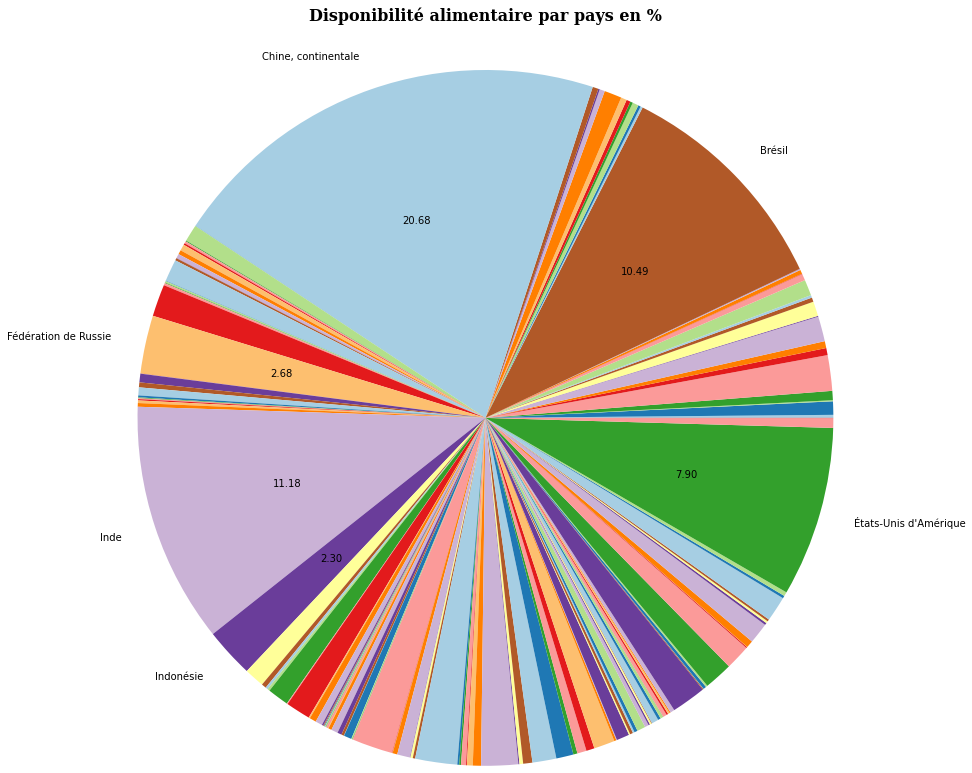

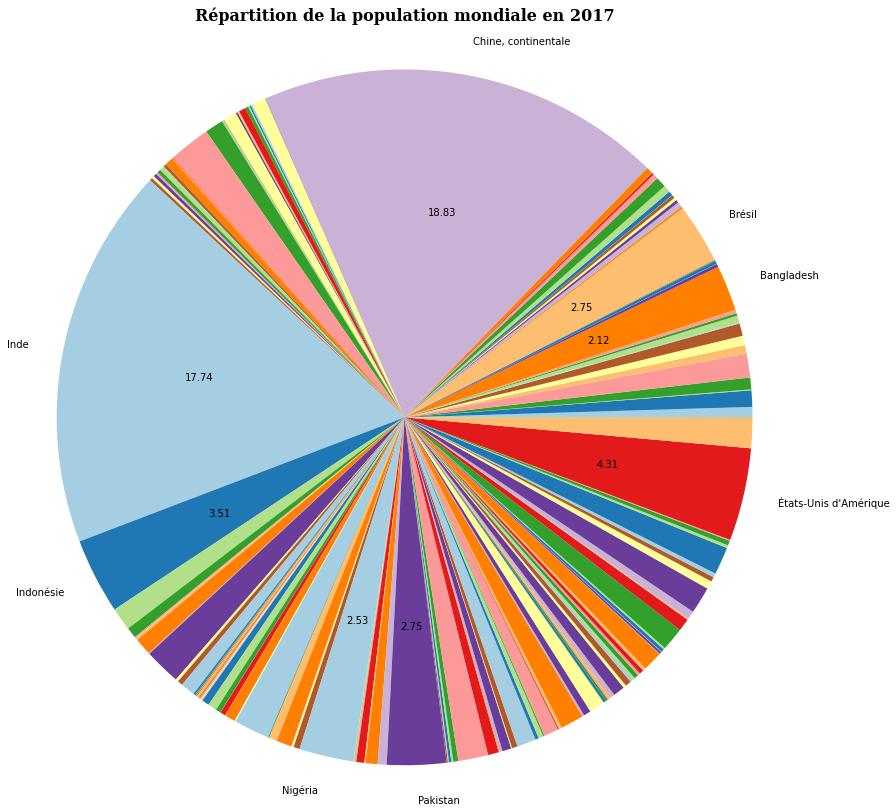

Zone,Disponibilité intérieure,Ratio de disponibilité du pays sur Disponibilté mondiale
"Chine, continentale","2,036,726.0",20.68%
Inde,"1,100,838.0",11.18%
Brésil,"1,033,314.0",10.49%
États-Unis d'Amérique,"777,992.0",7.90%
Fédération de Russie,"263,784.0",2.68%
Indonésie,"226,930.0",2.30%
Nigéria,"192,388.0",1.95%
Mexique,"186,709.0",1.90%
Pakistan,"168,631.0",1.71%
Allemagne,"162,275.0",1.65%


Année,Zone,Total population,Part de la population mondiale
2017,"Chine, continentale","1,421,021,791.0",18.83%
2017,Inde,"1,338,676,785.0",17.74%
2017,États-Unis d'Amérique,"325,084,756.0",4.31%
2017,Indonésie,"264,650,963.0",3.51%
2017,Brésil,"207,833,823.0",2.75%
2017,Pakistan,"207,906,209.0",2.75%
2017,Nigéria,"190,873,244.0",2.53%
2017,Bangladesh,"159,685,424.0",2.12%
2017,Fédération de Russie,"145,530,082.0",1.93%
2017,Japon,"127,502,725.0",1.69%


In [8]:


col_index1 = 'Ratio de disponibilité du pays sur Disponibilté mondiale'
col_index2 = 'Total population'
col_index3 = 'Part de la population mondiale'
#Create table total country's food domestic availability
total_avail = g_avail.groupby(zone)[[dom_avail]].sum().reset_index()
world_total_avail_2017 = total_avail.sum(axis = 0)[1]
# Adding a ratio column country's food domestic availability/worldwide food avail
total_avail[col_index1] = ratio_f(total_avail[dom_avail],world_total_avail_2017)


#create copy for plot
plot_total_avail = total_avail.copy()

#Create table population by country
total_pop_per_year_and_zone = g_demog.groupby([year,zone])[value].sum().reset_index(name=col_index2)
total_pop_per_year_and_zone_2017 = total_pop_per_year_and_zone[total_pop_per_year_and_zone[year]==2017]
# Add a column that represent country's share of world population
total_pop_per_year_and_zone_2017[col_index3] = ratio_f(total_pop_per_year_and_zone_2017[col_index2],POP_2017)

#create copy for plot
plot_total_pop_per_year_and_zone_2017 = total_pop_per_year_and_zone_2017.copy()

# we drop country that are below 2% either on world share population and world share availability
for i, row in plot_total_avail.iterrows():
    if row[col_index1] <=2:
        plot_total_avail.at[i,zone] = ''

for i, row in plot_total_pop_per_year_and_zone_2017.iterrows():
    if row[col_index3] <=2:
        plot_total_pop_per_year_and_zone_2017.at[i,zone] = ''

#Create classic pie chart with title size, color...
plt.figure(facecolor='white')
clrs = sns.color_palette('Paired')
plt.title('Disponibilité alimentaire par pays en %', y=2.3,fontdict= title_font())
#Share is shown only if it's above 2 % same for the two charts
plt.pie(plot_total_avail[col_index1],labels = plot_total_avail[zone],autopct=lambda p: format(p, '.2f') if p > 2 else None,colors = clrs, radius=4)
plt.savefig(img_path+'Disponibilité alimentaire par pays en %'+img_extension,dpi=300, bbox_inches='tight')
plt.show()

plt.figure(facecolor='white')

plt.title('Répartition de la population mondiale en 2017', y=2.3,fontdict= title_font())
plt.pie(plot_total_pop_per_year_and_zone_2017[col_index3],labels = plot_total_pop_per_year_and_zone_2017[zone],autopct=lambda p: format(p, '.2f') if p > 2 else None,colors = clrs, radius=4)
plt.savefig(img_path+'Répartition de la population mondiale en 2017'+img_extension,dpi=300, bbox_inches='tight')
plt.show()
total_avail = total_avail.sort_values(by=col_index1,ascending=False).head(10)
total_pop_per_year_and_zone_2017 = total_pop_per_year_and_zone_2017.sort_values(by=col_index3,ascending=False).head(10)

format_datas(total_pop_per_year_and_zone_2017,col_index2,'{:,}')
format_datas(total_pop_per_year_and_zone_2017,col_index3,'{:,.2f}%')


format_datas(total_avail,dom_avail,'{:,}')
format_datas(total_avail,col_index1,'{:,.2f}%')


display(HTML(total_avail.to_html(index=False)))
display(HTML(total_pop_per_year_and_zone_2017.to_html(index=False)))




# Quelle est la part de la disponibilité utilisée par la nourriture, la nourriture animale et les pertes ?

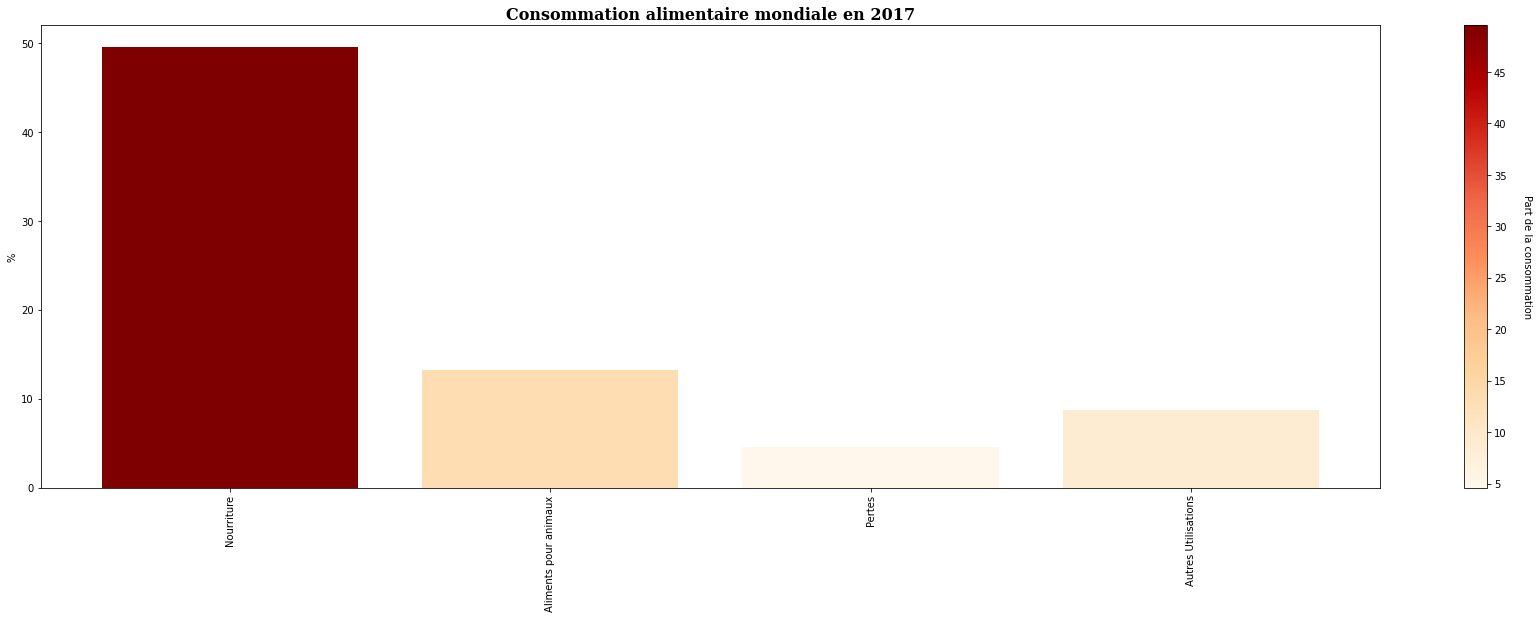

,Consommation et disponibilité alimentaire mondiale en 2017,Ratio consommation sur disponibilité
Disponibilité intérieure,"9,848,994.0",100.00%
Nourriture,"4,876,258.0",49.51%
Aliments pour animaux,"1,304,245.0",13.24%
Pertes,"453,698.0",4.61%
Autres Utilisations,"865,023.0",8.78%


In [9]:
#Result 4
col_index1 = 'Consommation et disponibilité alimentaire mondiale en 2017'
col_index2 = 'Ratio consommation sur disponibilité'
#Sum of four columns by country from global availanility table 
total_avail_cons = g_avail.groupby(zone)[[dom_avail,food,animal_food,loss,other_use]].sum()

#Create new table with pandas display
total_avail_cons = pd.DataFrame({col_index1:total_avail_cons.sum(axis=0)})
total_avail_cons[col_index2] = 0

# Create a ratio for each value over domestic food availability
for i in range(len(total_avail_cons)):
    total_avail_cons.iloc[i,1] = ratio_f(total_avail_cons.iloc[i,0],total_avail_cons.iloc[0,0])

#Create bar chart by using the proper function
ylab = total_avail_cons['Ratio consommation sur disponibilité'][1:]
xlab = [food, animal_food,loss,other_use]
bar_color(xlab,ylab,'Consommation alimentaire mondiale en 2017','%','Part de la consommation','OrRd')
format_datas(total_avail_cons,col_index1,'{:,}')
format_datas(total_avail_cons,col_index2,'{:,.2f}%')
display(total_avail_cons)

# Quels sont les 10 pays le plus en sous-nutritions ?

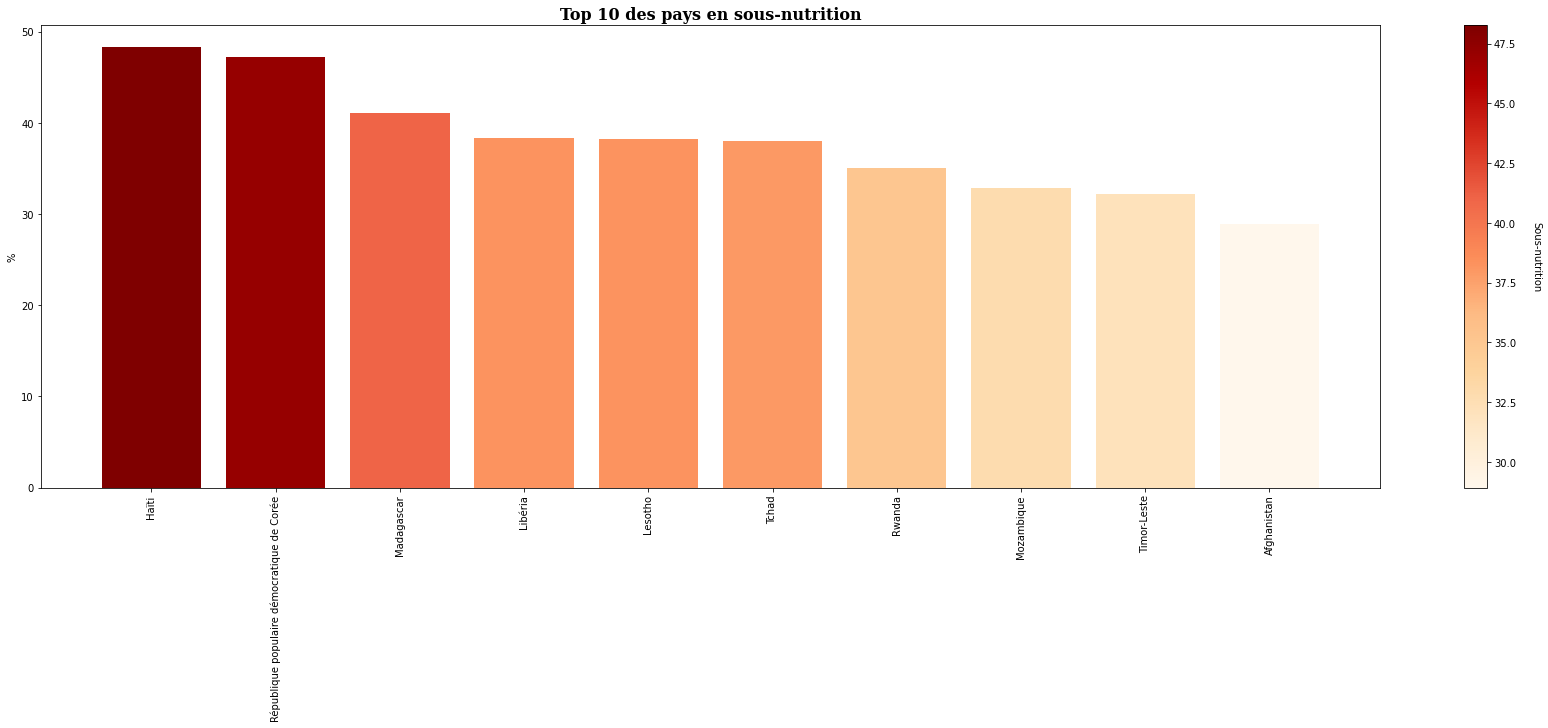

Année,Zone,Population en sous-nutrition,Total population,Ratio de personnes en sous-nutrition en 2017
2017,Haïti,"5,300,000.0","10,982,366.0",48.26%
2017,République populaire démocratique de Corée,"12,000,000.0","25,429,825.0",47.19%
2017,Madagascar,"10,500,000.0","25,570,512.0",41.06%
2017,Libéria,"1,800,000.0","4,702,226.0",38.28%
2017,Lesotho,"800,000.0","2,091,534.0",38.25%
2017,Tchad,"5,700,000.0","15,016,753.0",37.96%
2017,Rwanda,"4,200,000.0","11,980,961.0",35.06%
2017,Mozambique,"9,400,000.0","28,649,018.0",32.81%
2017,Timor-Leste,"400,000.0","1,243,258.0",32.17%
2017,Afghanistan,"10,500,000.0","36,296,113.0",28.93%


In [10]:
#Result 5
col_index1 = 'Population en sous-nutrition'
col_index2 = 'Total population'
col_index3 = 'Ratio de personnes en sous-nutrition en 2017'

#Create table with group by and sum already seen before
undern_pop_per_year_and_zone = g_undern.groupby([year,zone])[value].sum().reset_index(name=col_index1)
total_pop_per_year_and_zone = g_demog.groupby([year,zone])[value].sum().reset_index(name=col_index2)
#Filter on 2017
total_pop_per_year_and_zone_2017 = total_pop_per_year_and_zone[total_pop_per_year_and_zone[year]==2017]

#Merging tables created previously with inner join on zone and year
undern_country_ratio = pd.merge(undern_pop_per_year_and_zone,total_pop_per_year_and_zone_2017,how='inner',on=[zone,year])

undern_country_ratio[col_index3] = ratio_f(undern_country_ratio[col_index1],undern_country_ratio[col_index2])
#Sort by undernourishment ratio, sorted in descending. Only the ten first values are displayed 
undern_country_ratio =undern_country_ratio.sort_values(by=col_index3, ascending=False).head(10)


#Create bar chart by using the proper function
ylab = undern_country_ratio[col_index3]
xlab = undern_country_ratio[zone]
bar_color(xlab,ylab,'Top 10 des pays en sous-nutrition','%','Sous-nutrition','OrRd')
format_datas(undern_country_ratio,col_index3,'{:,.2f}%')
format_datas(undern_country_ratio,col_index1,'{:,}')
format_datas(undern_country_ratio,col_index2,'{:,}')
# Format that dismisses indexes on display	
display(HTML(undern_country_ratio.to_html(index=False)))

# Quels sont les 10 pays les plus aidés ?

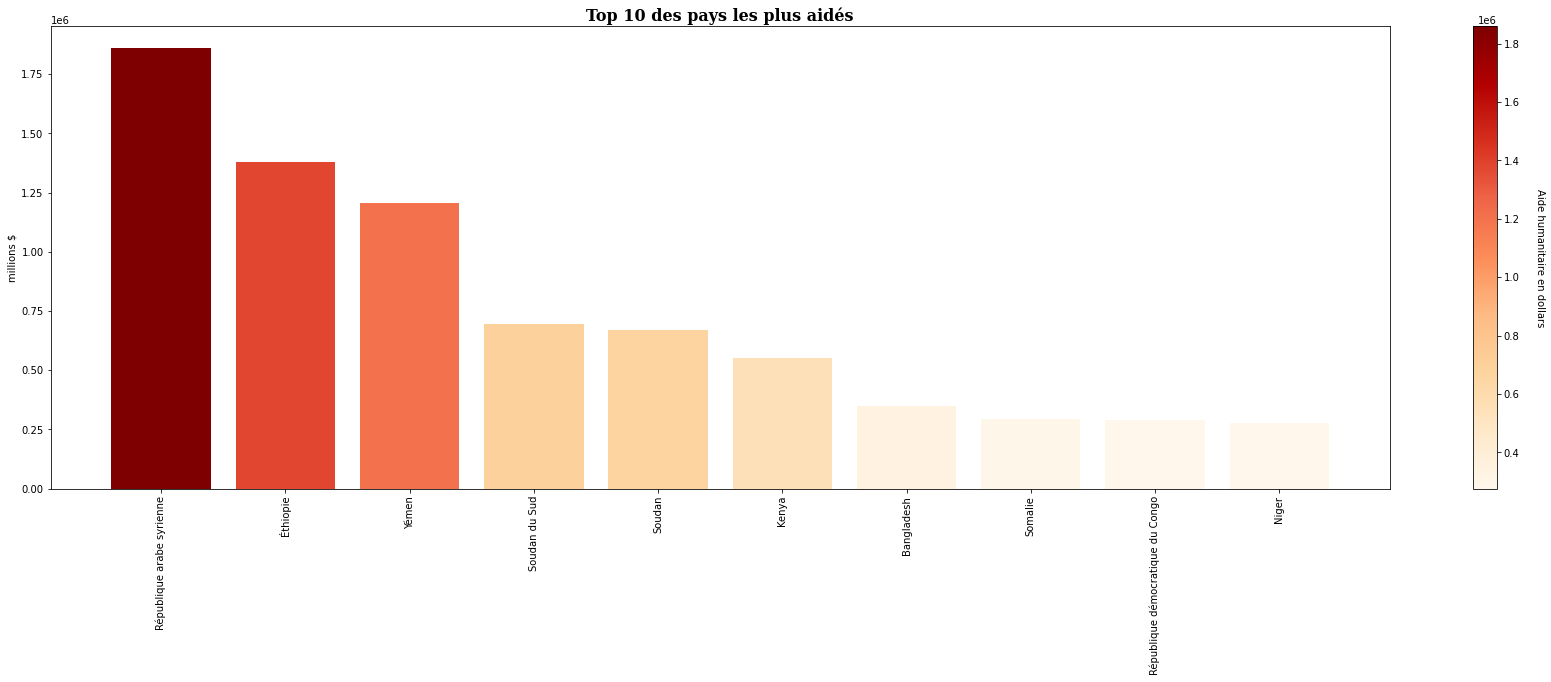

Pays bénéficiaire,Total des aides alimentaire depuis 2013
République arabe syrienne,"$ 1,858,943"
Éthiopie,"$ 1,381,294"
Yémen,"$ 1,206,484"
Soudan du Sud,"$ 695,248"
Soudan,"$ 669,784"
Kenya,"$ 552,836"
Bangladesh,"$ 348,188"
Somalie,"$ 292,678"
République démocratique du Congo,"$ 288,502"
Niger,"$ 276,344"


In [11]:
#Result 6

col_index1 = 'Total des aides alimentaire depuis 2013'
#Create table with group by and sum already seen before
aid_by_country = g_aid.groupby(beneficiary_c)[value].sum().reset_index(name=col_index1)
aid_by_country=aid_by_country.sort_values(by=col_index1,ascending=False).head(10)

#Create bar chart by using the proper function
ylab = aid_by_country['Total des aides alimentaire depuis 2013']
xlab = aid_by_country[beneficiary_c]
bar_color(xlab,ylab,'Top 10 des pays les plus aidés','millions $','Aide humanitaire en dollars','OrRd')
format_datas(aid_by_country,col_index1,'$ {:,}')
display(HTML(aid_by_country.to_html(index=False)))

# Quels sont les 10 pays avec le moins de disponibilité alimentaire par habitant ?

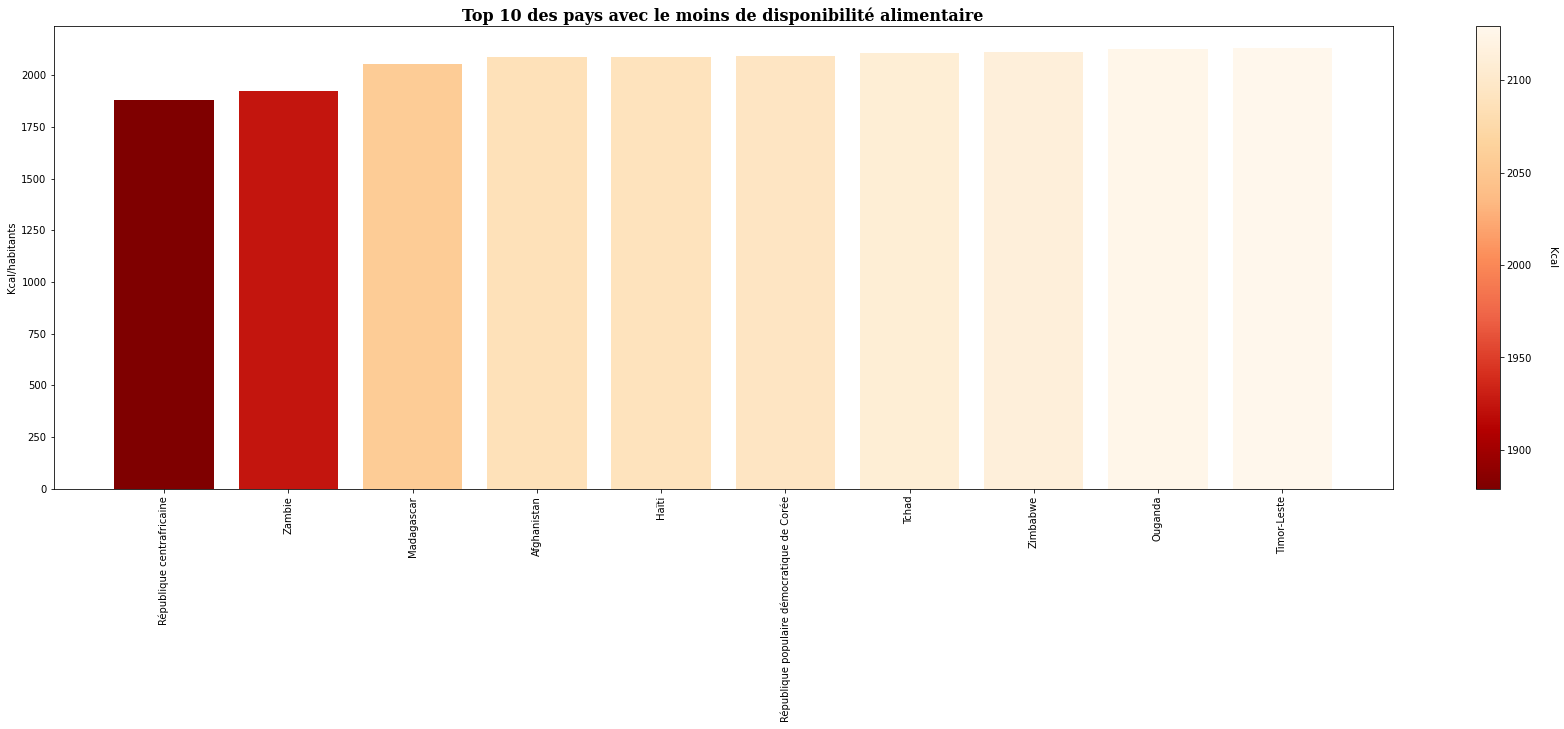

Année,Zone,Total population,Total disponibilité alimentaire par habitants
2017,République centrafricaine,"4,596,023.0","1,879.0 kcal"
2017,Zambie,"16,853,599.0","1,924.0 kcal"
2017,Madagascar,"25,570,512.0","2,056.0 kcal"
2017,Afghanistan,"36,296,113.0","2,087.0 kcal"
2017,Haïti,"10,982,366.0","2,089.0 kcal"
2017,République populaire démocratique de Corée,"25,429,825.0","2,093.0 kcal"
2017,Tchad,"15,016,753.0","2,109.0 kcal"
2017,Zimbabwe,"14,236,595.0","2,113.0 kcal"
2017,Ouganda,"41,166,588.0","2,126.0 kcal"
2017,Timor-Leste,"1,243,258.0","2,129.0 kcal"


In [12]:
#Result 7
col_index1 = 'Total disponibilité alimentaire par habitants'
#Create table with group by and sum already seen before
disp_alim_per_inha = g_avail.groupby(zone)[avail_kcal_p].sum().reset_index(name =col_index1)
disp_alim_per_inha = pd.merge(total_pop_per_year_and_zone_2017,disp_alim_per_inha,how='inner',on=[zone])
disp_alim_per_inha = disp_alim_per_inha.sort_values(by=col_index1,ascending=True).head(10)


#Create bar chart by using the proper function
ylab = disp_alim_per_inha[col_index1]
xlab = disp_alim_per_inha[zone]
bar_color(xlab,ylab,'Top 10 des pays avec le moins de disponibilité alimentaire','Kcal/habitants','Kcal','OrRd_r')
format_datas(disp_alim_per_inha,col_index1,'{:,} kcal')
format_datas(disp_alim_per_inha,'Total population','{:,}')
display(HTML(disp_alim_per_inha.to_html(index=False)))

# Que représente la consommation de céréale dans la consommation alimentaire mondiales ?

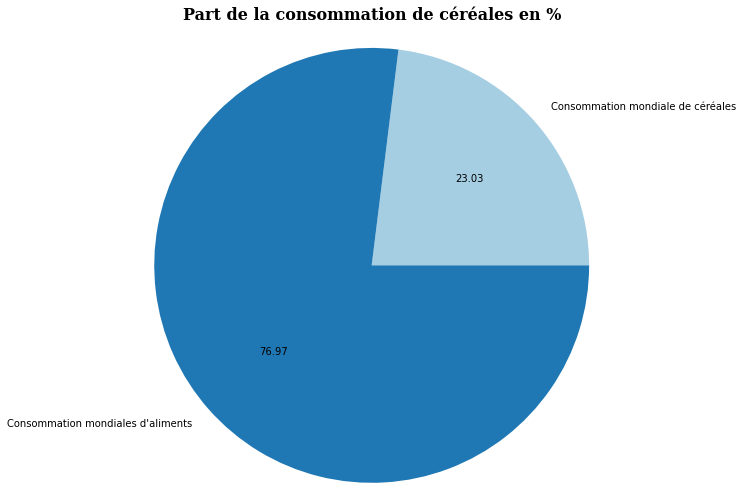

Type de consommation,Quantité en millier de tonnes
Consommation mondiale de céréales,"2,244,452.0"
Consommation mondiales d'aliments,"7,499,224.0"


In [13]:
col_index1 = 'Consommation total'
col_index2 = 'Type de consommation'
col_index3 = 'Quantité en millier de tonnes'

#Create table with group by and sum already seen before 
world_food_cons = g_avail.groupby(product)[[dom_avail,food,animal_food,other_use,loss]].sum().reset_index()
world_food_cons[col_index1] = world_food_cons[[food,animal_food,other_use,loss]].sum(axis=1)

world_cereal_cons = world_food_cons[world_food_cons[product].isin(cereals)]
total_food_cons = world_food_cons[col_index1].sum()
total_cereal_cons = world_cereal_cons[col_index1].sum()


cons_type = ['Consommation mondiale de céréales','Consommation mondiales d'+"'"+'aliments']
data = {col_index2:cons_type,col_index3 :[total_cereal_cons,total_food_cons] }
cereal_cons_on_food = pd.DataFrame(data)

# Create plot chart already seen before
plt.figure(facecolor='white')
plt.pie(cereal_cons_on_food[col_index3],labels=cons_type,autopct='%.2f',radius=2.5,colors = clrs)
clrs = sns.color_palette('Paired')
plt.title('Part de la consommation de céréales en %', y=1.6,fontdict= title_font())
plt.savefig(img_path+'Part de la consommation de céréales en %'+img_extension,dpi=300, bbox_inches='tight')
plt.show()
format_datas(cereal_cons_on_food,col_index3,'{:,}')
display(HTML(cereal_cons_on_food.to_html(index=False)))


# Que devrait être la part des céréales dans l'alimentation humaine si les céréales était destinés uniquement à l'alimentation humaine ?

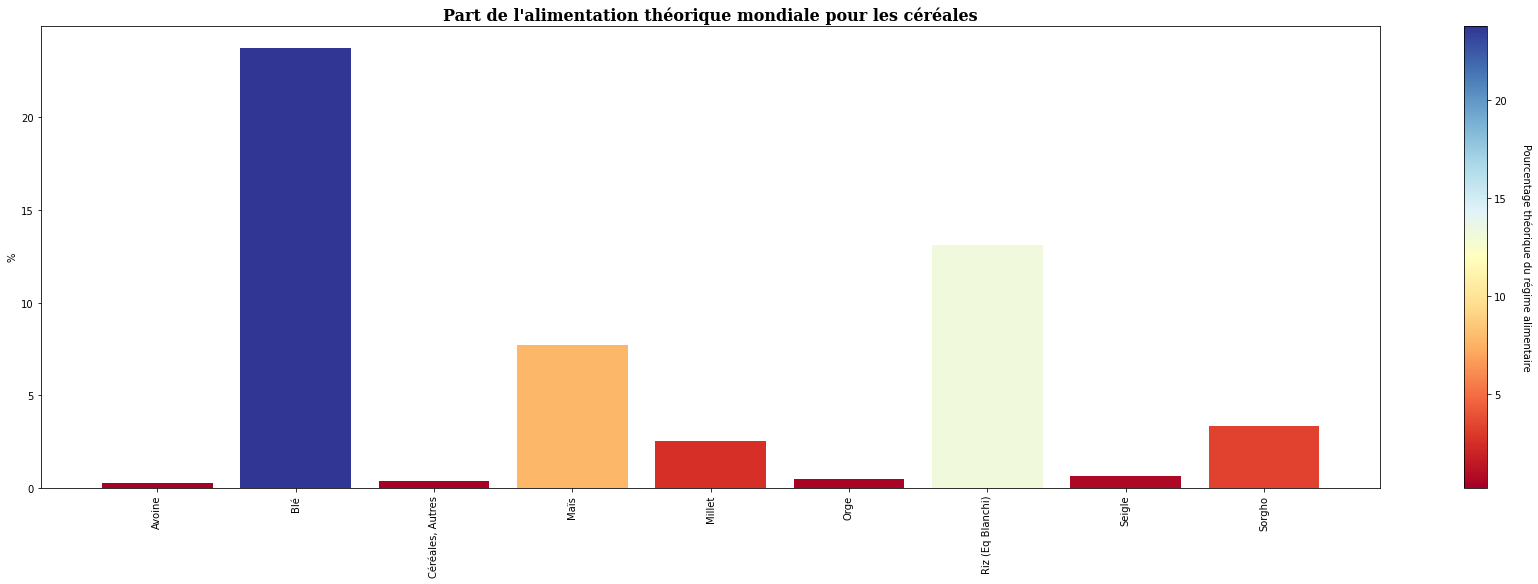

Produit,Disponibilité alimentaire (Kcal/personne/jour),Part théorique dans le régime alimentaire
Avoine,5.57,0.24%
Blé,552.48,23.76%
"Céréales, Autres",8.72,0.38%
Maïs,179.67,7.73%
Millet,59.19,2.55%
Orge,11.34,0.49%
Riz (Eq Blanchi),304.74,13.11%
Seigle,15.02,0.65%
Sorgho,77.38,3.33%


In [14]:

#Create table with group by and sum already seen before
col_index1 = 'Part théorique dans le régime alimentaire'
cons_cereale_kcal = g_avail.groupby(product)[avail_kcal_p].mean().reset_index()

cons_cereale_kcal = cons_cereale_kcal[cons_cereale_kcal[product].isin(cereals)]
cons_cereale_kcal[col_index1] = ratio_f(cons_cereale_kcal[avail_kcal_p],KCAL_CONS)

#Create bar chart by using the proper function
ylab = cons_cereale_kcal[col_index1]
xlab = cons_cereale_kcal[product]
bar_color(xlab,ylab,'Part de l'+"'"+'alimentation théorique mondiale pour les céréales','%','Pourcentage théorique du régime alimentaire','RdYlBu')
format_datas(cons_cereale_kcal,col_index1,'{:,.2f}%')
cons_cereale_kcal [avail_kcal_p]= round(cons_cereale_kcal[avail_kcal_p],2)
display(HTML(cons_cereale_kcal.to_html(index=False)))

# Quel est la répartion entre la nourriture humaine et l'alimentation animale pour les céréales ?

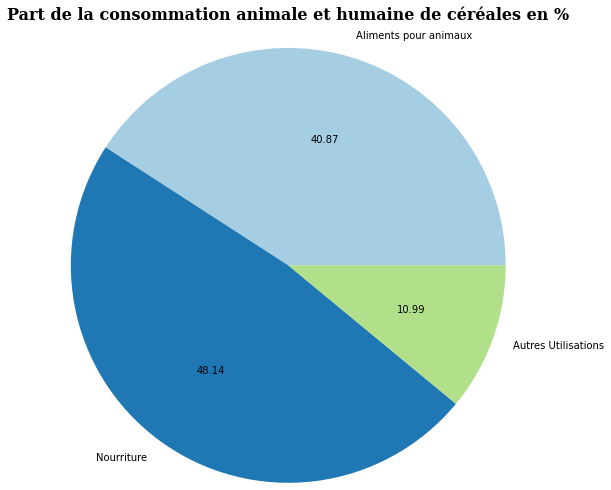

type de consommation,Quantité en millier de tonne
Aliments pour animaux,"873,535.0"
Nourriture,"1,029,010.0"
Autres Utilisations,"234,787.0"


In [15]:
col_index1 ='type de consommation'
col_index2 = 'Quantité en millier de tonne'
#Create table with group by and sum already seen before
total_share_cons_cereale = g_avail.groupby(product)[[animal_food,food,other_use]].sum().reset_index()
total_share_cons_cereale = total_share_cons_cereale[total_share_cons_cereale[product].isin(cereals)]
total_share_cons_cereale = total_share_cons_cereale.sum(axis=0).reset_index()

total_share_cons_cereale = total_share_cons_cereale.rename(columns={total_share_cons_cereale.columns[0]:col_index1,total_share_cons_cereale.columns[1]:col_index2})
total_share_cons_cereale = total_share_cons_cereale.drop(total_share_cons_cereale.index[0])
#Classic pie chart is creating
plt.figure(facecolor='white')
plt.pie(total_share_cons_cereale[col_index2],labels=total_share_cons_cereale[col_index1],autopct='%.2f',radius=2.5,colors = clrs)
clrs = sns.color_palette('Paired')
plt.title('Part de la consommation animale et humaine de céréales en %', y=1.6,fontdict= title_font())
plt.savefig(img_path+'Part de la consommation animale et humaine de céréales en %'+img_extension,dpi=300, bbox_inches='tight')
plt.show()
format_datas(total_share_cons_cereale,col_index2,'{:,}')
display(HTML(total_share_cons_cereale.to_html(index=False)))

# Quel est la répartion entre la nourriture humaine et l'alimentation animale par céréales ?

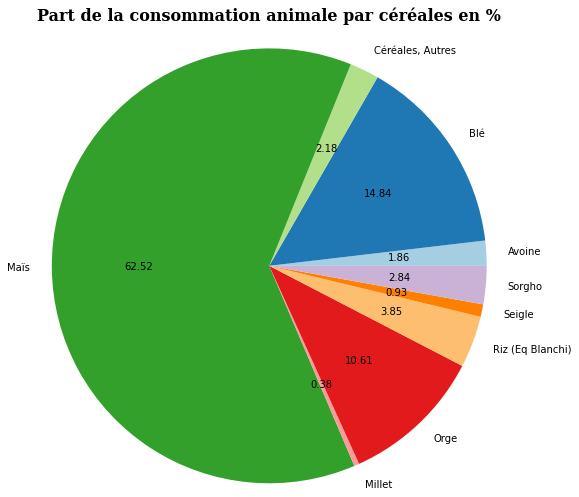

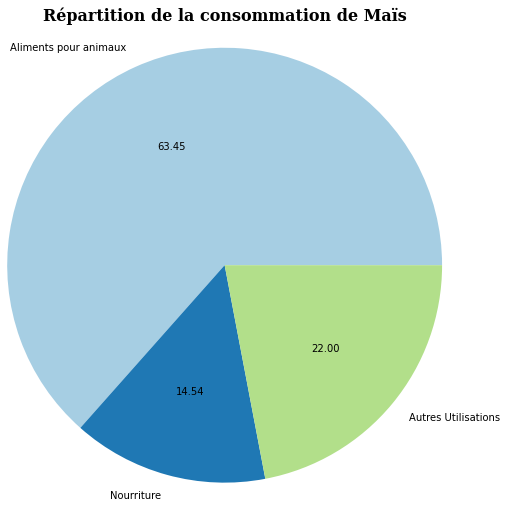

Produit,Aliments pour animaux,Nourriture,Autres Utilisations,Part de la consommation de nourriture mondiale,Part de la consommation de nourriture animale mondiale,Part de la consommation des autress utilisations mondiale en %
Avoine,"16,251.0","3,903.0",206.0,0.08%,1.25%,0.02%
Blé,"129,668.0","457,824.0","22,424.0",9.39%,9.94%,1.72%
"Céréales, Autres","19,035.0","5,324.0","1,388.0",0.11%,1.46%,0.11%
Maïs,"546,116.0","125,184.0","189,386.0",2.57%,41.87%,14.52%
Millet,"3,306.0","23,040.0",196.0,0.47%,0.25%,0.02%
Orge,"92,658.0","6,794.0",654.0,0.14%,7.10%,0.05%
Riz (Eq Blanchi),"33,594.0","377,286.0","18,464.0",7.74%,2.58%,1.42%
Seigle,"8,099.0","5,502.0",20.0,0.11%,0.62%,0.00%
Sorgho,"24,808.0","24,153.0","2,049.0",0.50%,1.90%,0.16%


,Maïs
Aliments pour animaux,"546,116.0"
Nourriture,"125,184.0"
Autres Utilisations,"189,386.0"


In [16]:
#Result 9

from ipaddress import collapse_addresses


col_index1 = 'Part de la consommation de nourriture mondiale'
col_index2 = 'Part de la consommation de nourriture animale mondiale'
col_index3 = 'Part de la consommation des autress utilisations mondiale en %'
share_cons_cereale = g_avail.groupby(product)[[animal_food,food,other_use]].sum().reset_index()

w_food_cons = g_avail[food].sum()

w_animal_food_cons = g_avail[animal_food].sum()

w_other_cons = g_avail[animal_food].sum()
# Global view on cereals consumption
share_cons_cereale = share_cons_cereale[share_cons_cereale[product].isin(cereals)]
share_cons_cereale[col_index1] = ratio_f(share_cons_cereale[food],w_food_cons)
share_cons_cereale[col_index2] = ratio_f(share_cons_cereale[animal_food],w_animal_food_cons)
share_cons_cereale[col_index3] = ratio_f(share_cons_cereale[other_use],w_other_cons)

#Focus on corn consumption
corn_table = share_cons_cereale[share_cons_cereale[product]=='Maïs']
corn_table = corn_table.transpose()
corn_table = corn_table.drop([product,col_index1,col_index2,col_index3])
corn_table = corn_table.rename(columns={corn_table.columns[0]:'Maïs'})
# pie chart cereal and animal food 
plt.figure(facecolor='white')
plt.pie(share_cons_cereale[animal_food],labels=share_cons_cereale[product],autopct='%.2f',radius=2.5,colors = clrs)
plt.title('Part de la consommation animale par céréales en %', y=1.6,fontdict= title_font())
plt.savefig(img_path+'Part de la consommation animal, humaine et autre de maïs en %'+img_extension,dpi=300, bbox_inches='tight')
plt.show()
# pie chart overall corn consumption 
plt.figure(facecolor='white')
plt.pie(corn_table['Maïs'],labels=corn_table.index,autopct='%.2f',radius=2.5,colors = clrs)
plt.title('Répartition de la consommation de Maïs', y=1.6,fontdict= title_font())
plt.savefig(img_path+'Répartition de la consommation de Maïs'+img_extension,dpi=300, bbox_inches='tight')
plt.show()

format_datas(share_cons_cereale,animal_food,'{:,}')
format_datas(share_cons_cereale,food,'{:,}')
format_datas(share_cons_cereale,other_use,'{:,}')
format_datas(share_cons_cereale,col_index1,'{:,.2f}%')
format_datas(share_cons_cereale,col_index2,'{:,.2f}%')
format_datas(share_cons_cereale,col_index3,'{:,.2f}%')
format_datas(corn_table,'Maïs','{:,}')
display(HTML(share_cons_cereale.to_html(index=False)))
display(corn_table)



# Comment se présente les exportations d'un pays comme la Thaïlande ?

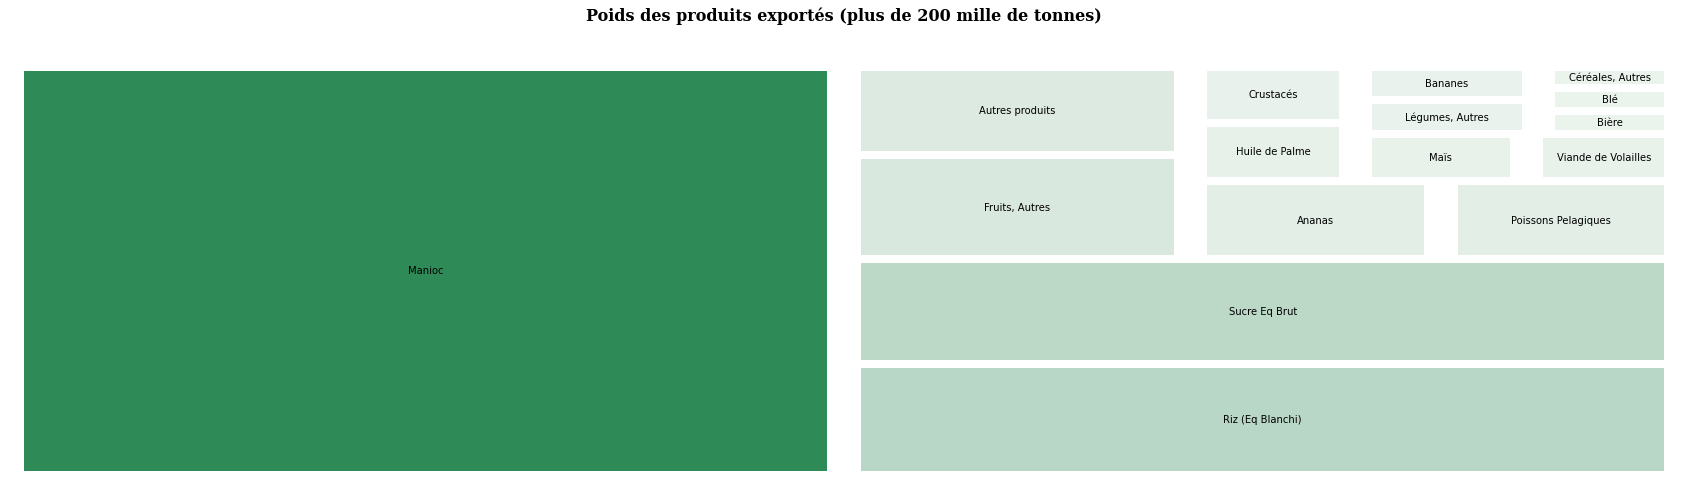

Zone,Produit,Production,Exportations,Total production mondiale,Total exportations mondiale,Classement production mondiale,Classement exportations mondiale
Thaïlande,Manioc,"30,228.0","25,214.0","255,002.0","36,052.0",1,1
Thaïlande,Riz (Eq Blanchi),"24,054.0","6,860.0","495,447.0","41,445.0",1,3
Thaïlande,Sucre Eq Brut,"10,024.0","6,462.0","179,206.0","68,320.0",1,2
Thaïlande,"Fruits, Autres","6,141.0","2,671.0","203,580.0","30,165.0",1,1
Thaïlande,Autres produits,"11,250.0","2,248.0","2,925,887.0","557,037.0",0,0
Thaïlande,Ananas,"2,209.0","1,449.0","24,274.0","7,670.0",1,3
Thaïlande,Poissons Pelagiques,595.0,"1,390.0","36,632.0","23,134.0",1,2
Thaïlande,Huile de Palme,"1,970.0",713.0,"53,612.0","50,673.0",1,5
Thaïlande,Crustacés,718.0,678.0,"12,603.0","5,229.0",1,2
Thaïlande,Maïs,"5,063.0",591.0,"1,017,029.0","128,787.0",1,19


In [17]:
#Result 10

col_index1 = 'Production'
col_index2 = 'Exportations'
col_index3 = 'Total production mondiale'
col_index4 = 'Total exportations mondiale'
col_index5 = 'Classement production mondiale'
col_index6 = 'Classement exportations mondiale'

#Create production and export table
country_export_table = g_avail.groupby([zone,product])[[production,export]].sum().reset_index()

# Filter on Thaïland and export value >0
disp_country = country_export_table[(country_export_table[zone]== 'Thaïlande')&(country_export_table[export]!=0)]

# 
prodexport_table = g_avail.groupby(product)[[production,export]].sum().reset_index()
##Create ranking columns
country_export_table[col_index5] = country_export_table.groupby('Produit')[product].rank('dense',ascending=False)
country_export_table[col_index6] = country_export_table.groupby('Produit')['Exportations - Quantité'].rank('dense',ascending=False)

disp_country = pd.merge(disp_country,prodexport_table,how = 'inner',on=[product])
disp_country = pd.merge(disp_country,country_export_table,how = 'inner',on=[product,zone])


# Drop columns 
disp_country= disp_country.drop(columns={disp_country.columns[6],disp_country.columns[7]})
#Renaming columnns
disp_country.rename(columns={disp_country.columns[2]:col_index1,disp_country.columns[3]:col_index2,disp_country.columns[4]:col_index3,disp_country.columns[5]:col_index4},inplace=True)

#dismiss values <=200 thousands tons

for i, row in disp_country.iterrows():
    new_product_value = 'Autres produits'
    if row[col_index2] <=200:
        disp_country.at[i,product] = new_product_value
        disp_country.at[i,col_index5] = 0
        disp_country.at[i,col_index6] = 0
disp_country = disp_country.groupby([zone,product]).sum().reset_index()

disp_country = disp_country.sort_values(by=col_index2,ascending = False)
# Abscissa values
xlab = disp_country[product]
#ordinate values
ylab = disp_country[col_index2]

#Color palette that is used for the chart
cmap = sns.light_palette("seagreen", as_cmap=True)
mini=min(disp_country[col_index2])
maxi=max(disp_country[col_index2])

# create a color gradient with exportation weight
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in disp_country[col_index2]]

#Create the treemap chart 
squarify.plot(sizes=ylab,label = xlab, color=colors, pad = True)

plt.title('Poids des produits exportés (plus de 200 mille de tonnes)',fontdict=title_font(),x=0.5, y=1.1)
plt.axis('off')
plot_size()
plt.savefig(img_path+'Poids des produits exportés (plus de 200 mille de tonnes)'+img_extension,dpi=300, bbox_inches='tight')
plt.show()

format_datas(disp_country,production,'{:,}')
format_datas(disp_country,col_index3,'{:,}')
format_datas(disp_country,col_index4,'{:,}')
format_datas(disp_country,col_index2,'{:,}')
disp_country[col_index5] = disp_country[col_index5].astype(int)
disp_country[col_index6] = disp_country[col_index6].astype(int)
display(HTML((disp_country.head(10)).to_html(index=False)))



# Qui sont les plus importateurs de manioc dans le monde ?

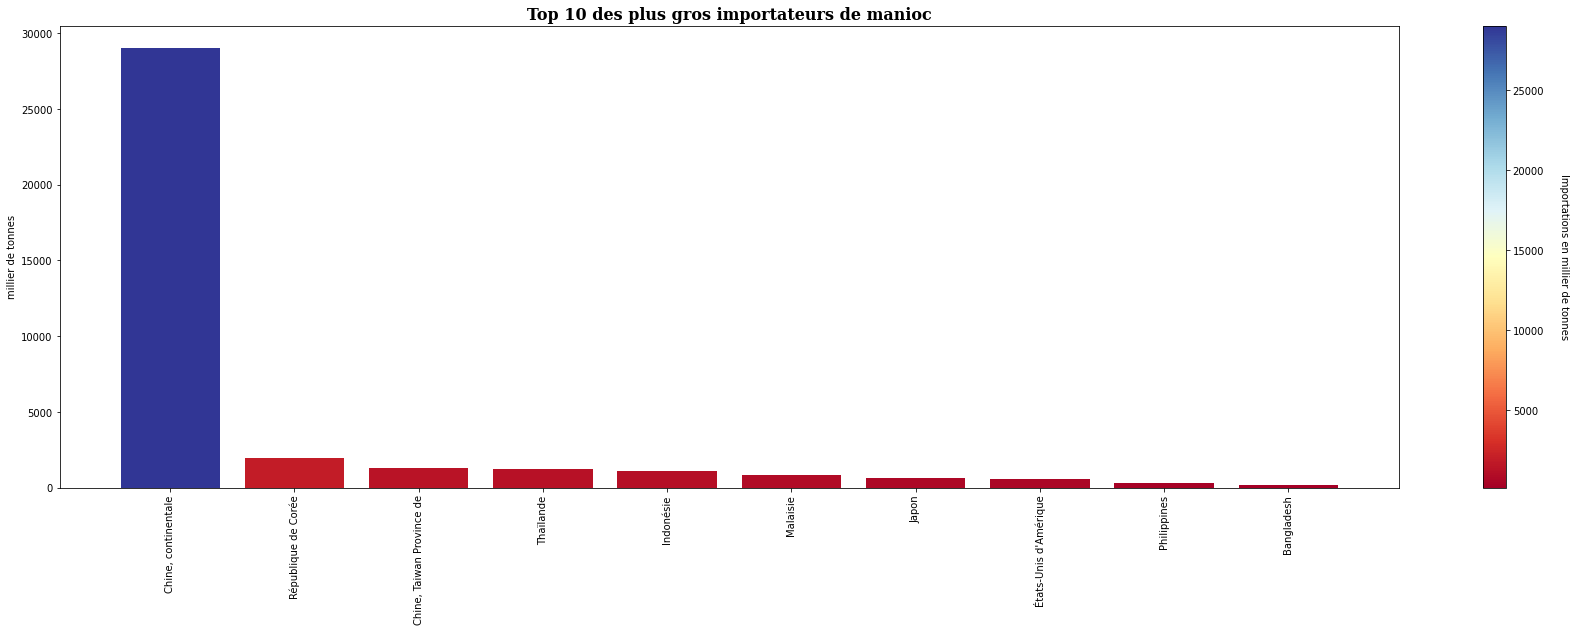

Zone,Produit,Importations - Quantité,Nourriture,Aliments pour animaux,Autres Utilisations
"Chine, continentale",Manioc,"29,046.0","2,645.0","22,868.0","7,940.0"
République de Corée,Manioc,"1,933.0",5.0,0.0,123.0
"Chine, Taiwan Province de",Manioc,"1,324.0",1.0,1.0,"1,317.0"
Thaïlande,Manioc,"1,250.0",871.0,"1,800.0","2,081.0"
Indonésie,Manioc,"1,102.0","11,735.0",480.0,"8,894.0"
Malaisie,Manioc,844.0,61.0,3.0,836.0
Japon,Manioc,637.0,11.0,0.0,0.0
États-Unis d'Amérique,Manioc,588.0,46.0,288.0,245.0
Philippines,Manioc,276.0,"2,289.0",142.0,201.0
Bangladesh,Manioc,147.0,23.0,0.0,124.0


In [18]:
#Result 11
#create consumptions and import table 
manioc_table = g_avail.groupby([zone,product])[[importation,food,animal_food,other_use]].sum().reset_index()
# Focus on manioc
manioc_table = manioc_table[manioc_table[product]=='Manioc']

manioc_table = manioc_table.sort_values(by=importation,ascending= False).head(10)
#Create bar chart using the proper function
ylab = manioc_table[importation]
xlab = manioc_table[zone]
bar_color(xlab,ylab,'Top 10 des plus gros importateurs de manioc','millier de tonnes','Importations en millier de tonnes','RdYlBu')
format_datas(manioc_table,food,'{:,}')
format_datas(manioc_table,animal_food,'{:,}')
format_datas(manioc_table,other_use,'{:,}')
format_datas(manioc_table,importation,'{:,}')
display(HTML(manioc_table.to_html(index=False)))
